#Import Data

In [ ]:
import kagglehub
from glob import glob

# Download the dataset
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

# Use the downloaded path for locating the files
dataset_path = f"{path}/Dataset_BUSI_with_GT/*/*"

100%|██████████| 195M/195M [00:10<00:00, 20.4MB/s]

Extracting files...


In [ ]:
# Common
import tensorflow as tf
from glob import glob
import numpy as np

# Data
from sklearn.model_selection import train_test_split
import cv2

# Data visualization
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

#Data Preparation

In [ ]:
# Use glob to get all image and mask file paths
paths = glob(dataset_path)

# Print summary of each class and total counts
print(f'\033[92m')
print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")



'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
size = 128   # image size: 128x128
X, y = load_data(root_path = dataset_path, size = size)

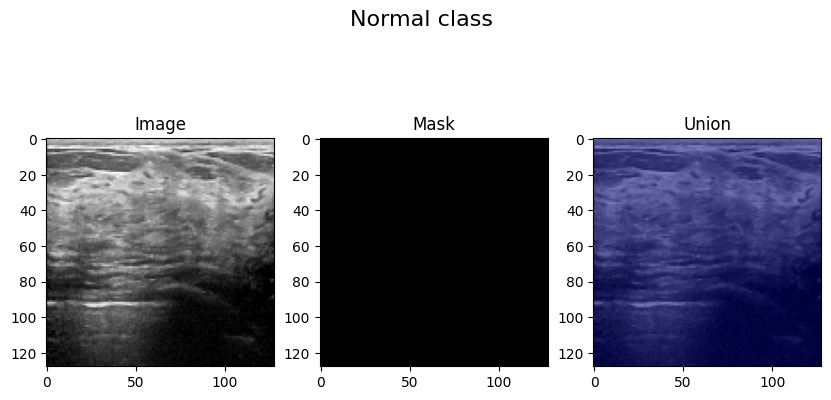

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

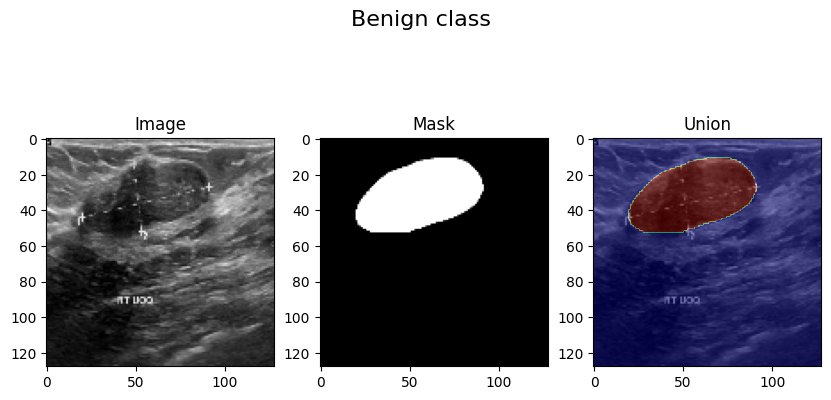

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

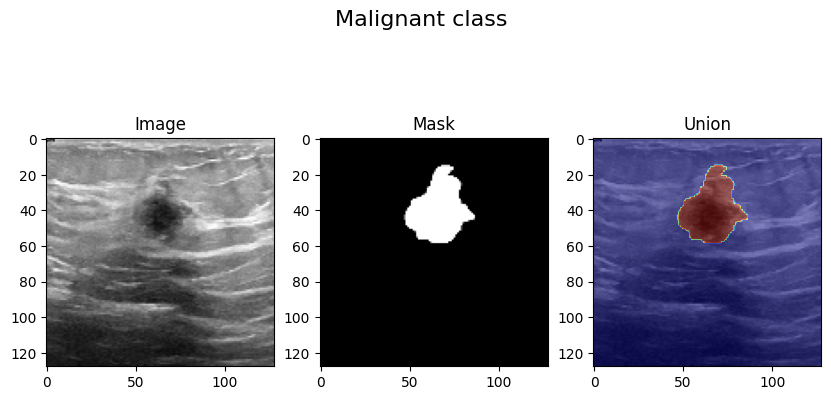

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(tf.squeeze(y[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

In [ ]:
# drop normal class because normal class has not mask
X = X[:647]
y = y[:647]

print(f"X shape: {X.shape}     |  y shape: {y.shape}")

# prepare data to modeling
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)


print(f"\nX shape: {X.shape}  |  y shape: {y.shape}")

X shape: (647, 128, 128)     |  y shape: (647, 128, 128)

X shape: (647, 128, 128, 1)  |  y shape: (647, 128, 128, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print(f'\033[92m')
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)


X_train shape: (582, 128, 128, 1)
y_train shape: (582, 128, 128, 1)
X_test shape: (65, 128, 128, 1)
y_test shape: (65, 128, 128, 1)


#UNet Model

In [ ]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [ ]:
def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

In [ ]:
def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_84[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 64, 64, 64)     │              0 │ conv2d_85[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_86[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 32, 32, 128)    │              0 │ conv2d_87[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_88[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 16, 16, 256)    │              0 │ conv2d_89[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_90[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 8, 8, 512)      │              0 │ conv2d_91[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_92[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_93[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18       

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs = 30, validation_data = (X_test,y_test))

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8968 - loss: 0.5550 - val_accuracy: 0.9095 - val_loss: 0.3296
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 48s 131ms/step - accuracy: 0.9022 - loss: 0.3450 - val_accuracy: 0.9095 - val_loss: 0.2879
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9035 - loss: 0.2994 - val_accuracy: 0.9095 - val_loss: 0.2832
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9058 - loss: 0.3056 - val_accuracy: 0.9095 - val_loss: 0.2609
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9031 - loss: 0.2573 - val_accuracy: 0.9112 - val_loss: 0.2131
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9075 - loss: 0.2282 - val_accuracy: 0.9126 - val_loss: 0.2143
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9138 - loss: 0.2237 - val_accuracy: 0.9194 - val_loss: 0.2169
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9219 - loss: 0.1994 - val_accuracy: 0.

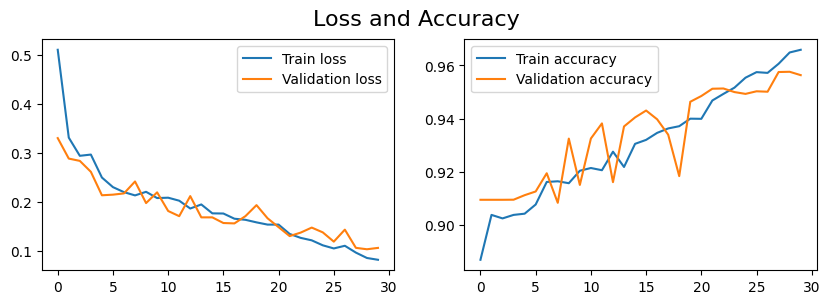

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

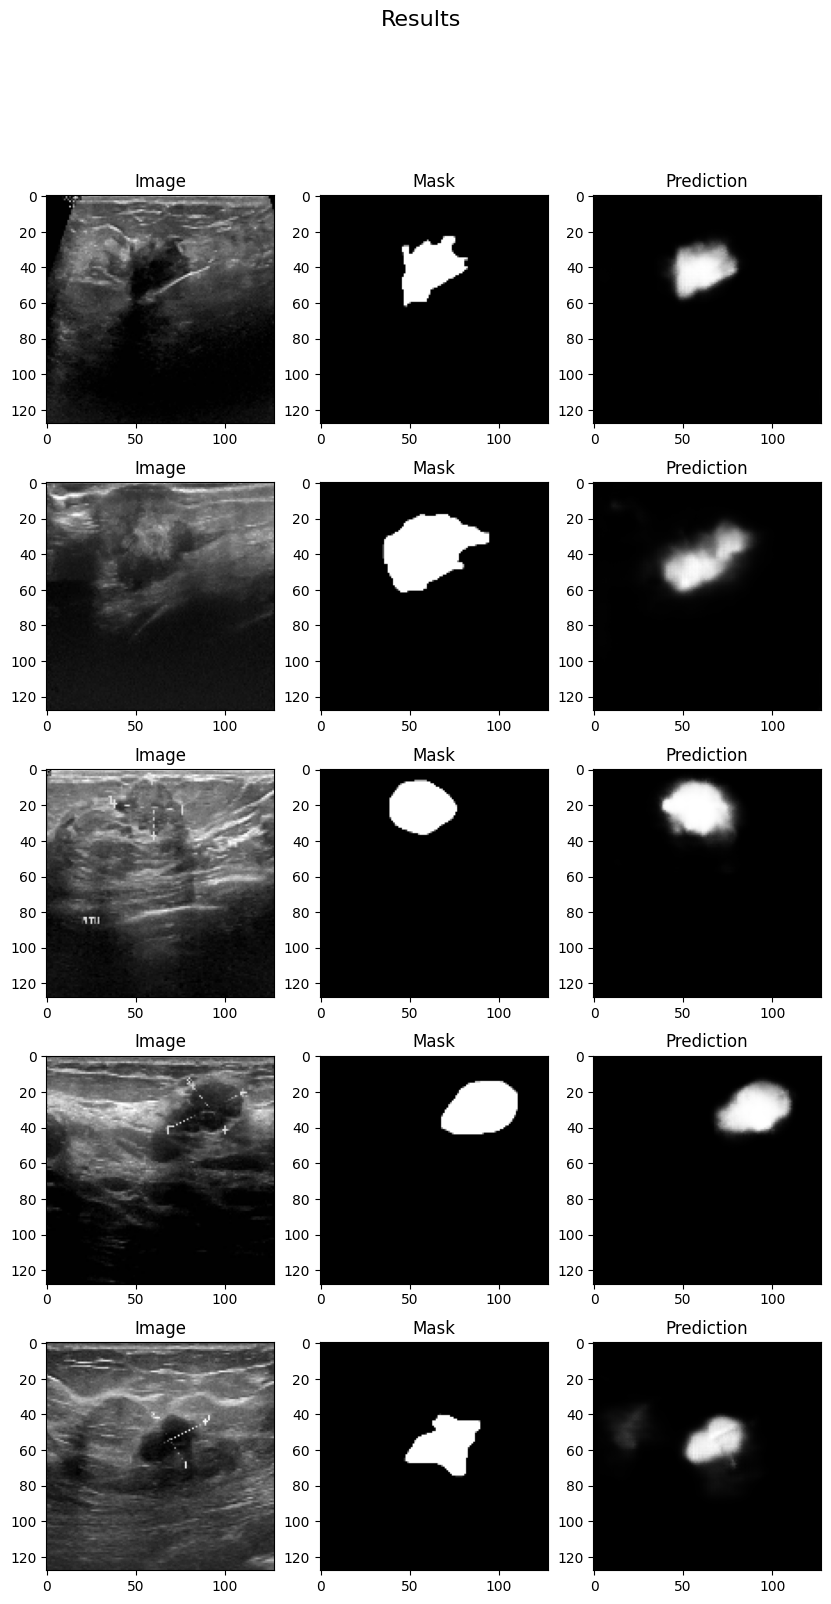

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()


In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)



Mean IoU = 0.7955816
Precision Score = 0.681
Recall Score = 0.882
F1 Score = 0.769


In [ ]:
# Save the model in HDF5 format
model.save('unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# UNet with Self-Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision

# Enable mixed precision if running on a compatible GPU
mixed_precision.set_global_policy('mixed_float16')

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv

def self_attention_block(x, num_heads=2, key_dim=4):
    """
    Self-attention block using MultiHeadAttention with reduced heads and key dimensions.
    """
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(0.1)(attn_output)
    out = Add()([x, attn_output])
    out = LayerNormalization()(out)
    return out

def encoder_with_self_attention(x, filters, num_heads=2, key_dim=4):
    x = conv_block(x, filters)
    x = self_attention_block(x, num_heads=num_heads, key_dim=key_dim)
    x = conv_block(x, filters)
    return x

def U_Net_with_SelfAttention(input_shape=(64, 64, 1), num_classes=1):
    # Input
    inputs = Input(input_shape)

    # Encoder
    x = conv_block(inputs, 16)
    skip1 = x
    x = MaxPooling2D((2, 2))(x)

    x = encoder_with_self_attention(x, 32)
    skip2 = x
    x = MaxPooling2D((2, 2))(x)

    x = encoder_with_self_attention(x, 64)
    skip3 = x
    x = MaxPooling2D((2, 2))(x)

    x = encoder_with_self_attention(x, 128)

    # Decoder
    x = conv_block(x, 64)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip3])
    x = conv_block(x, 64)

    x = conv_block(x, 32)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip2])
    x = conv_block(x, 32)

    x = conv_block(x, 16)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip1])
    x = conv_block(x, 16)

    # Final convolution
    outputs = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = U_Net_with_SelfAttention(input_shape=(64, 64, 1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
)

# Callbacks for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model_with_self_attention.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Function to preprocess images and targets: resize to (64, 64)
def preprocess_data(images, masks, target_size=(64, 64)):
    images_resized = tf.image.resize(images, target_size)
    masks_resized = tf.image.resize(masks, target_size)
    return images_resized, masks_resized

# Preprocess the training and validation data
X_train_processed, y_train_processed = preprocess_data(X_train, y_train)
X_test_processed, y_test_processed = preprocess_data(X_test, y_test)

# Train the model
history = model.fit(
    X_train_processed, y_train_processed,
    validation_data=(X_test_processed, y_test_processed),
    epochs=100,
    batch_size=1,
    callbacks=callbacks
)


Epoch 1/100
576/582 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8850 - io_u_5: 0.0000e+00 - loss: 0.3092
Epoch 1: val_loss improved from inf to 0.18992, saving model to best_model_with_self_attention.keras
582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.8853 - io_u_5: 0.0000e+00 - loss: 0.3084 - val_accuracy: 0.9244 - val_io_u_5: 0.0000e+00 - val_loss: 0.1899
Epoch 2/100
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9306 - io_u_5: 0.0000e+00 - loss: 0.1767
Epoch 2: val_loss did not improve from 0.18992
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9306 - io_u_5: 0.0000e+00 - loss: 0.1768 - val_accuracy: 0.9204 - val_io_u_5: 0.0000e+00 - val_loss: 0.1927
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9296 - io_u_5: 0.0000e+00 - loss: 0.1687
Epoch 3: val_loss did not improve from 0.18992
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9296 - io_u_5: 0.0000e+00 - loss: 0.1687 - val_accuracy: 0.8915 - val_io_u_5: 0.0000e+00 - val_lo

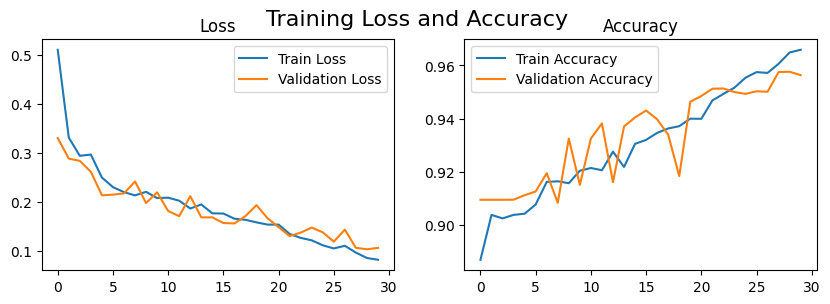

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

# Plotting Training Loss and Accuracy
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[0].legend()
ax[0].set_title("Loss")

ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")
ax[1].legend()
ax[1].set_title("Accuracy")
fig.suptitle("Training Loss and Accuracy", fontsize=16)
plt.show()

In [ ]:
j = np.random.randint(0, X_test_processed.shape[0], 5)
for i in range(5):
    ax[i, 0].imshow(X_test_processed[j[i]], cmap='gray')
    ax[i, 0].set_title("Test Image")
    ax[i, 1].imshow(y_test_processed[j[i]], cmap='gray')
    ax[i, 1].set_title("True Mask")
    prediction = model.predict(np.expand_dims(X_test_processed[j[i]], axis=0), verbose=0)
    ax[i, 2].imshow(prediction[0, :, :, 0], cmap='gray')
    ax[i, 2].set_title("Predicted Mask")

fig.suptitle("Test Images, True Masks, and Predictions", fontsize=16)
plt.show()

In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.592996
Precision Score = 0.311
Recall Score = 0.633
F1 Score = 0.417


In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 64, 64, 16)     │            160 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 64, 64, 16)     │             64 │ conv2d_70[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_65             │ (None, 64, 64, 16)     │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 32, 32, 16)     │              0 │ activation_65[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 32, 32, 32)     │          4,640 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_66    │ (None, 32, 32, 32)     │            128 │ conv2d_71[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_66             │ (None, 32, 32, 32)     │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_15   │ (None, 32, 32, 32)     │          1,080 │ activation_66[0][0],   │
│ (MultiHeadAttention)      │                        │                │ activation_66[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 32, 32, 32)     │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 32, 32, 32)     │              0 │ activation_66[0][0],   │
│                           │                        │                │ dropout_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 32, 32, 32)     │             64 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_67    │ (None, 32, 32, 32)     │            128 │ conv2d_72[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_67        

 Total params: 1,483,313 (5.66 MB)

 Trainable params: 493,977 (1.88 MB)

 Non-trainable params: 1,376 (5.38 KB)

 Optimizer params: 987,960 (3.77 MB)

In [ ]:
model.save('UNet+SelfAttention.keras')

# FPN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(input, num_filters, kernel_size=3):
    """
    Basic convolution block with two conv layers
    """
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_fpn_model(input_shape=(128, 128, 1), num_filters=[64, 128, 256, 512]):
    """
    Build FPN model for medical image segmentation
    """
    # Input
    inputs = Input(input_shape)

    # Encoder/Backbone (similar to standard CNN architecture)
    # C1, C2, C3, C4 are the backbone features
    c1 = conv_block(inputs, num_filters[0])
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, num_filters[1])
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, num_filters[2])
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, num_filters[3])
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    bridge = conv_block(p4, num_filters[3]*2)

    # Feature Pyramid Network (FPN)
    # Build top-down pathway and lateral connections

    # Top level of pyramid
    p5 = Conv2D(num_filters[3], (1, 1), padding='same')(bridge)

    # P4
    p4_up = Conv2DTranspose(num_filters[3], (2, 2), strides=(2, 2), padding='same')(p5)
    p4_lateral = Conv2D(num_filters[3], (1, 1), padding='same')(c4)
    p4 = Add()([p4_up, p4_lateral])
    p4 = conv_block(p4, num_filters[3], kernel_size=3)

    # P3
    p3_up = Conv2DTranspose(num_filters[2], (2, 2), strides=(2, 2), padding='same')(p4)
    p3_lateral = Conv2D(num_filters[2], (1, 1), padding='same')(c3)
    p3 = Add()([p3_up, p3_lateral])
    p3 = conv_block(p3, num_filters[2], kernel_size=3)

    # P2
    p2_up = Conv2DTranspose(num_filters[1], (2, 2), strides=(2, 2), padding='same')(p3)
    p2_lateral = Conv2D(num_filters[1], (1, 1), padding='same')(c2)
    p2 = Add()([p2_up, p2_lateral])
    p2 = conv_block(p2, num_filters[1], kernel_size=3)

    # Final upsampling and fusion
    p1_up = Conv2DTranspose(num_filters[0], (2, 2), strides=(2, 2), padding='same')(p2)
    p1_lateral = Conv2D(num_filters[0], (1, 1), padding='same')(c1)
    p1 = Add()([p1_up, p1_lateral])
    p1 = conv_block(p1, num_filters[0], kernel_size=3)

    # Final convolution
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(p1)

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs], name='FPN')

    return model



In [ ]:
# Create and compile model
model_fpn = build_fpn_model(input_shape=(128, 128, 1))
model_fpn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training configuration
batch_size = 16
epochs = 30

# Training
history = model_fpn.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 587ms/step - accuracy: 0.7686 - loss: 0.5049 - val_accuracy: 0.1000 - val_loss: 173411.3438
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.9325 - loss: 0.2064 - val_accuracy: 0.1308 - val_loss: 111.9048
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.9367 - loss: 0.1829 - val_accuracy: 0.5172 - val_loss: 2.9580
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9464 - loss: 0.1493 - val_accuracy: 0.6437 - val_loss: 2.7978
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9468 - loss: 0.1490 - val_accuracy: 0.7928 - val_loss: 0.9380
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.9510 - loss: 0.1374 - val_accuracy: 0.8995 - val_loss: 0.3745
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.9505 - loss: 0.1289 - val_accuracy: 0.8716 - val_loss: 0.3653
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9545 - loss: 0.1196 - val_a

In [ ]:
model_fpn.summary()

Model: "FPN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 83,214,597 (317.44 MB)

 Trainable params: 27,734,273 (105.80 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 55,468,548 (211.60 MB)

In [ ]:
model.save('fpn_model.h5')


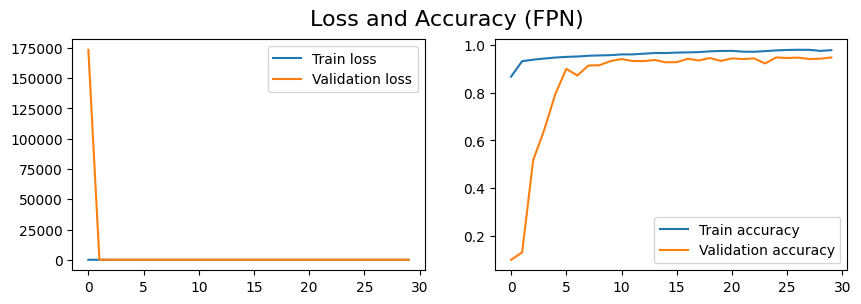

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()

# Plot accuracy
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()

fig.suptitle('Loss and Accuracy (FPN)', fontsize=16)
plt.show()


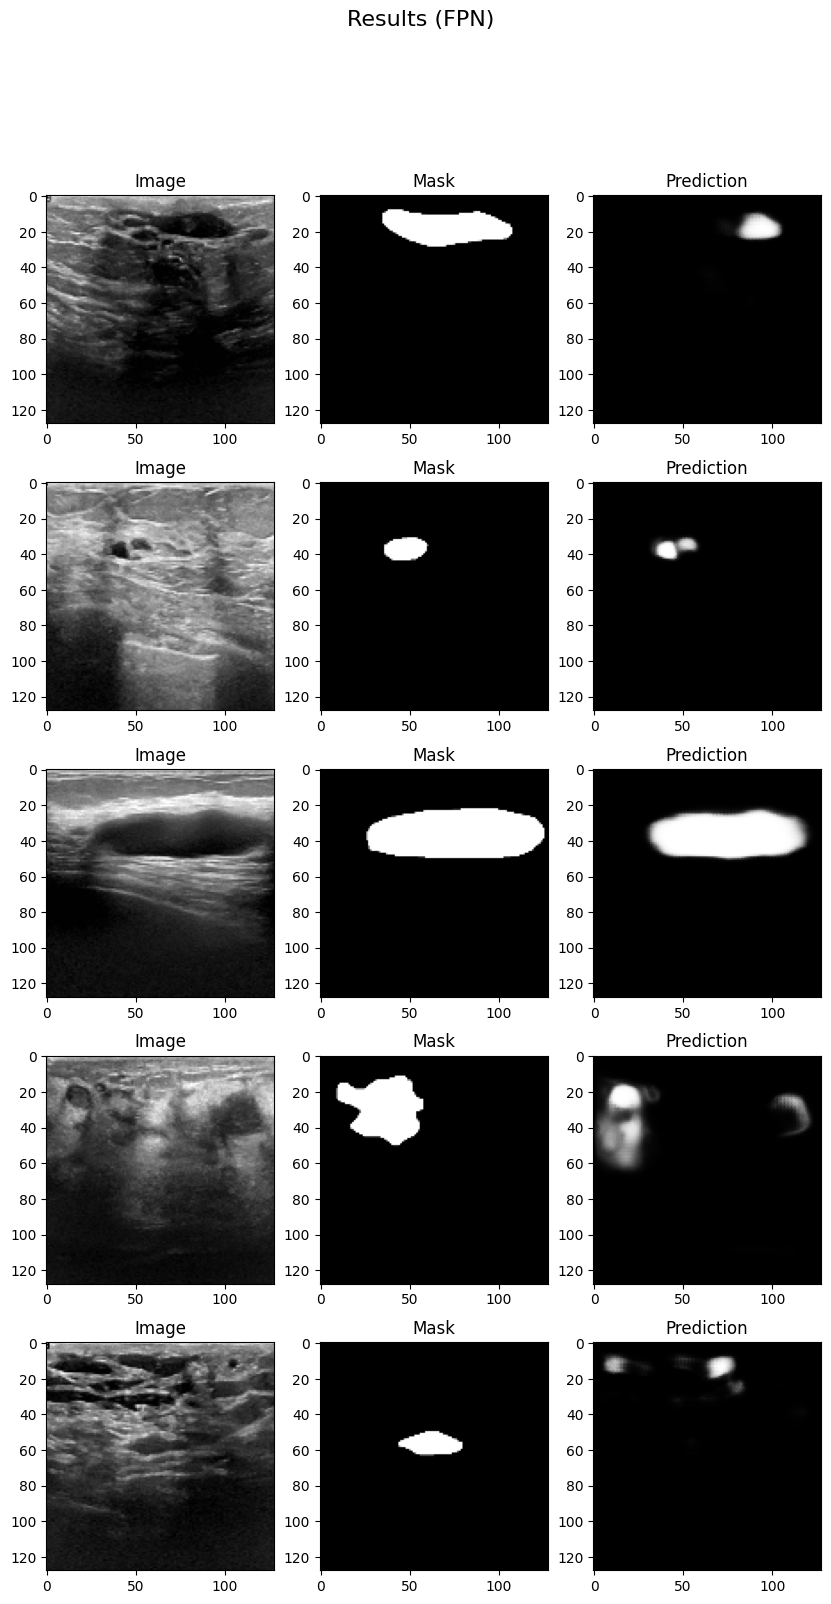

In [ ]:
# Plot the images, masks, and predictions for FPN model
fig, ax = plt.subplots(5, 3, figsize=(10, 18))

# Randomly select 5 images from the test set
j = np.random.randint(0, X_test.shape[0], 5)

# Display images, masks, and predictions
for i in range(5):
    # Plot original image
    ax[i, 0].imshow(X_test[j[i]], cmap='gray')
    ax[i, 0].set_title('Image')

    # Plot ground truth mask
    ax[i, 1].imshow(y_test[j[i]], cmap='gray')
    ax[i, 1].set_title('Mask')

    # Plot prediction from the FPN model
    ax[i, 2].imshow(model_fpn.predict(np.expand_dims(X_test[j[i]], 0), verbose=0)[0], cmap='gray')
    ax[i, 2].set_title('Prediction')

fig.suptitle('Results (FPN)', fontsize=16)
plt.show()


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/fpn_model.h5')


In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.8436196
Precision Score = 0.860
Recall Score = 0.810
F1 Score = 0.835


# PSPNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv

def pyramid_pooling_module(x, bin_sizes=[1, 2, 4, 8]):
    """
    Pyramid Pooling Module using proper Keras layers
    """
    h, w = K.int_shape(x)[1:3]
    concat_list = [x]

    for bin_size in bin_sizes:
        if bin_size == 1:
            # Global pooling case
            pool = GlobalAveragePooling2D()(x)
            pool = Reshape((1, 1, K.int_shape(x)[-1]))(pool)
            pool = Conv2D(512, (1, 1), padding='same')(pool)
            up = UpSampling2D(size=(h, w))(pool)
        else:
            # Calculate pool size
            pool_size = (h // bin_size, w // bin_size)
            # Ensure pool size is at least 1
            pool_size = (max(1, pool_size[0]), max(1, pool_size[1]))

            pool = AveragePooling2D(pool_size=pool_size, strides=pool_size)(x)
            pool = Conv2D(512, (1, 1), padding='same')(pool)
            up = UpSampling2D(size=pool_size)(pool)

        concat_list.append(up)

    return Concatenate(axis=-1)(concat_list)

def PSPNet(input_shape=(128, 128, 1), num_classes=1):
    # Input
    inputs = Input(input_shape)

    # Encoder
    # Initial block
    x = conv_block(inputs, 64)
    x = conv_block(x, 64)
    skip1 = x
    x = MaxPooling2D((2, 2))(x)

    # Second block
    x = conv_block(x, 128)
    x = conv_block(x, 128)
    skip2 = x
    x = MaxPooling2D((2, 2))(x)

    # Third block
    x = conv_block(x, 256)
    x = conv_block(x, 256)
    skip3 = x
    x = MaxPooling2D((2, 2))(x)

    # Fourth block
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    # Pyramid Pooling Module
    x = pyramid_pooling_module(x, bin_sizes=[1, 2, 4, 8])

    # Decoder
    x = conv_block(x, 256)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip3])
    x = conv_block(x, 256)

    x = conv_block(x, 128)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip2])
    x = conv_block(x, 128)

    x = conv_block(x, 64)
    x = UpSampling2D(size=(2, 2))(x)
    x = Concatenate()([x, skip1])
    x = conv_block(x, 64)

    # Final convolution
    outputs = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = PSPNet(input_shape=(128, 128, 1))

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])]
    )

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 128, 128, 64)   │            256 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_35             │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_35[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 128, 128, 64)   │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 64)     │              0 │ activation_36[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 64, 64, 128)    │            512 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_37             │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_37[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 64, 64, 128)    │            512 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10     

 Total params: 13,562,241 (51.74 MB)

 Trainable params: 13,556,609 (51.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8519 - io_u: 0.0000e+00 - loss: 0.3919   
Epoch 1: val_loss improved from inf to 31.96261, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8538 - io_u: 0.0000e+00 - loss: 0.3876 - val_accuracy: 0.0969 - val_io_u: 0.1064 - val_loss: 31.9626
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9272 - io_u: 0.0000e+00 - loss: 0.1991
Epoch 2: val_loss did not improve from 31.96261
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 304ms/step - accuracy: 0.9273 - io_u: 0.0000e+00 - loss: 0.1990 - val_accuracy: 0.0896 - val_io_u: 0.0949 - val_loss: 88.2919
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9255 - io_u: 0.0000e+00 - loss: 0.1977
Epoch 3: val_loss improved from 31.96261 to 0.90851, saving model to best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.9257 - io_u: 0.0000e+00 - loss: 0.1973 - val_accuracy: 0.7435 - val_io_u: 0.0483 - val_loss: 0.9085

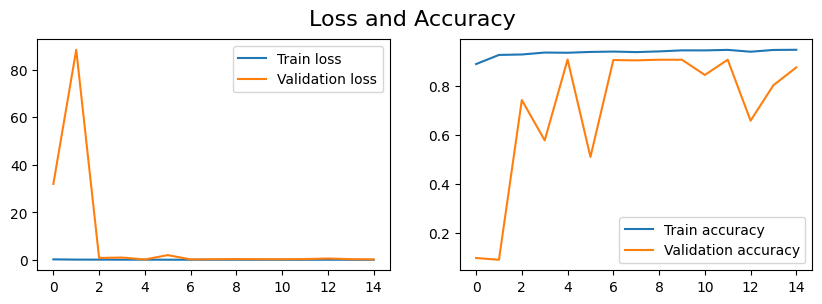

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

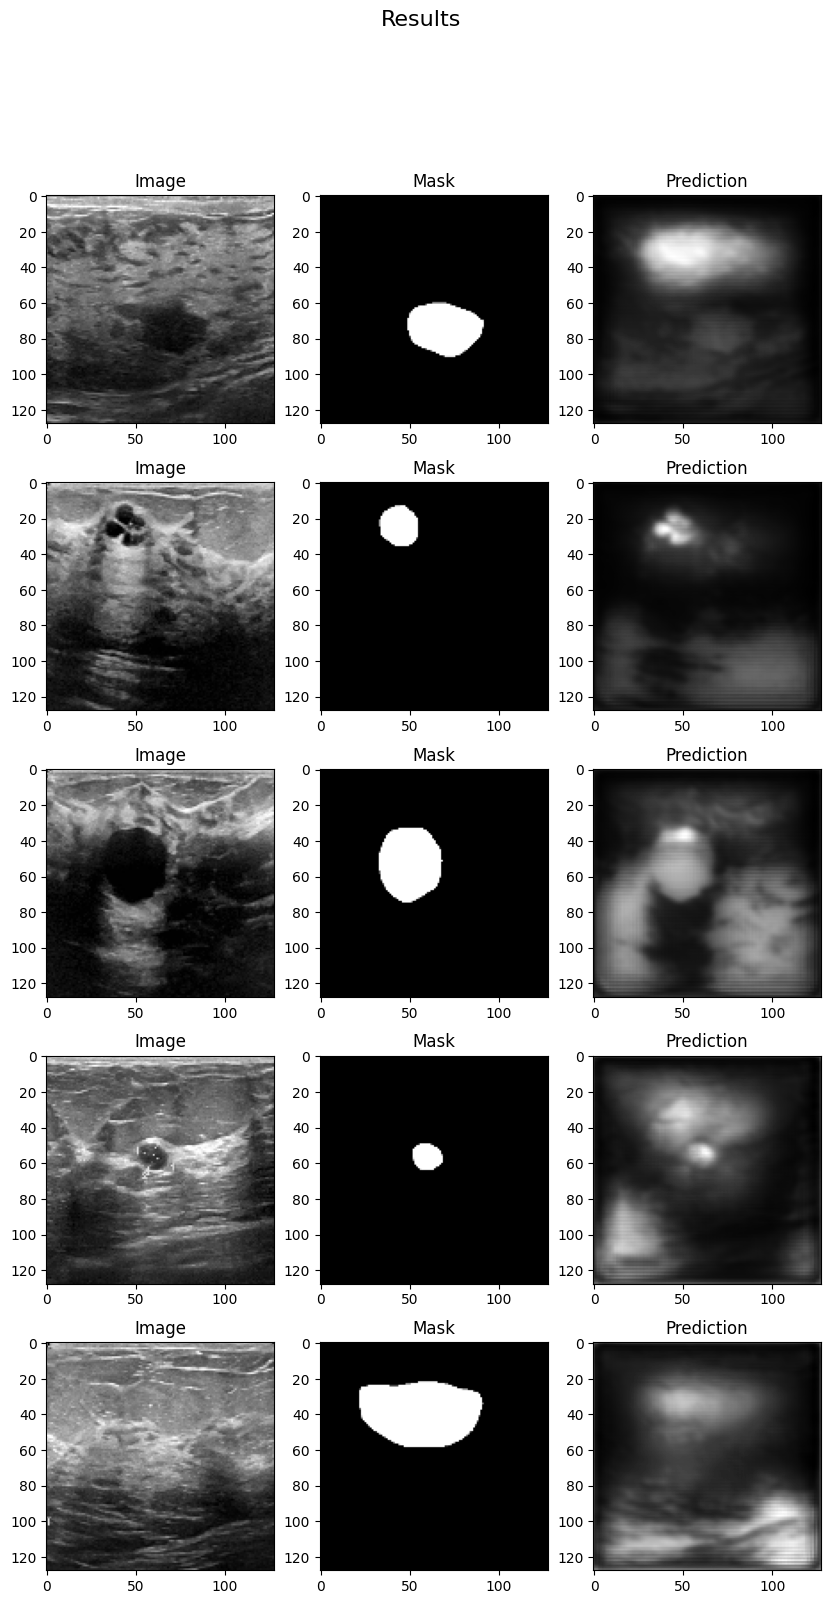

In [ ]:
fig, ax = plt.subplots(5,3, figsize=(10,18))

j = np.random.randint(0, X_test.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(X_test[j[i]], cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].imshow(y_test[j[i]], cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,2].imshow(model.predict(np.expand_dims(X_test[j[i]],0),verbose=0)[0], cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()


In [ ]:
print(f'\033[93m')
y_pred=model.predict(X_test,verbose=0)
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_test)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_test)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)


Mean IoU = 0.5150744
Precision Score = 0.134
Recall Score = 0.519
F1 Score = 0.212


In [ ]:
model.save('PSPNet_model.h5')

#Comparative Analysis

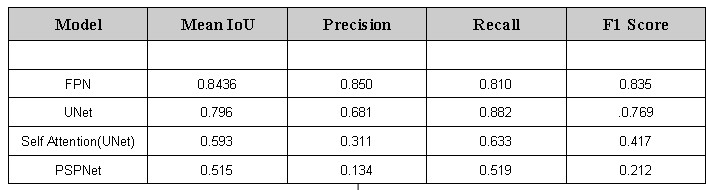

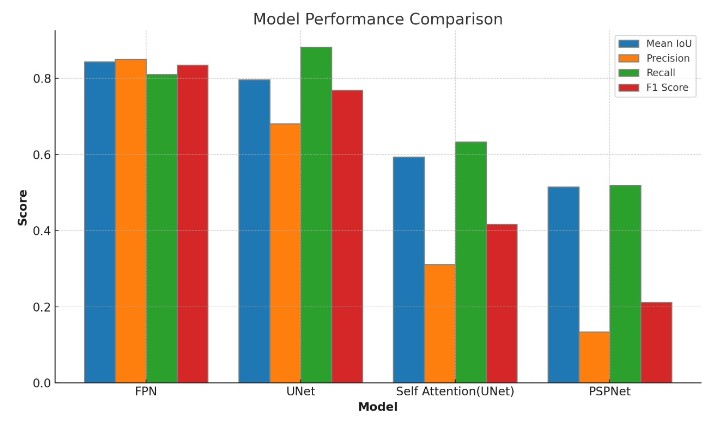